# Загрузка компонентов

In [213]:
%pylab inline

from collections import defaultdict, Counter

import matplotlib.pyplot as plt

import numpy
from scipy.stats import randint as sp_randint, expon as sp_expon
from pandas import DataFrame, Series, get_dummies
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, \
    RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.svm import LinearSVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


In [311]:
def prepare_df(df):
    df = get_dummies(df)
    labels = df.columns
    df = df - df.min('rows')
    df = df / df.max('rows')
    return df.fillna(0).as_matrix(), labels

In [372]:
CLS_METRICS = {
    'p' : metrics.precision_score,
    'r' : metrics.recall_score,
    'f1' : metrics.f1_score
}

REG_METRICS = {
    'mae' : metrics.mean_absolute_error,
    'evs' : metrics.explained_variance_score,
    'r2' : metrics.r2_score
}


def sort_dict_print(d):
    for k, v in sorted(d.viewitems(), key = lambda p: -p[1]):
        print '%10.4f\t%s' % (v, k)


def get_features_importance(clf, labels):
    try:
        clf = clf.best_estimator_
    except:
        try:
            clf = clf.get_params(True)['estimator']
        except:
            clf = None
    if clf is None:
        return {}
    try:
        assert len(labels) == len(clf.feature_importances_), "%r %r" % (len(labels), clf.feature_importances_.shape)
        return zip(labels, clf.feature_importances_)
    except Exception as ex:
        raise


def cls_cross_val(X, Y, feature_labels, pipeline, folds_n = 3, metrics = CLS_METRICS):
    result = {}
    features_imp = defaultdict(float)
    labels = list(set(Y))
    if len(labels) > 2:
        labels_ids = { label: i for i, label in enumerate(labels) }
        Y = label_binarize([labels_ids[label] for label in Y],
                           classes = [labels_ids[label] for label in labels])
    else:
        labels_ids = { True: 0 }
        Y = Y.reshape((Y.shape[0], 1))
    for label, label_i in labels_ids.viewitems():
        label_result = []
        label_Y = Y[:, label_i]
        if numpy.sum(label_Y) < folds_n:
            continue
        if folds_n == 1:
            all_idx = range(label_Y.shape[0])
            folds = [(all_idx, all_idx)]
        else:
            folds = StratifiedKFold(label_Y,
                                    n_folds = folds_n,
                                    shuffle = True)
        for train_idx, test_idx in folds:
            X_train, Y_train = X[train_idx], label_Y[train_idx]
            X_test, Y_test = X[test_idx], label_Y[test_idx]
            pipeline.fit(X_train, Y_train)
            for k, v in get_features_importance(pipeline, feature_labels):
                features_imp[k] += v
            Y_pred = pipeline.predict(X_test)
            label_result.append({metric_label : metric_func(Y_test, Y_pred)
                                 for metric_label, metric_func in metrics.viewitems() })
        result[label] = DataFrame(data = label_result).describe()
    result['OVERALL_MACRO_MEAN'] = DataFrame(data = [r.loc['mean']
                                                     for r
                                                     in result.viewvalues()]).describe()
    return result, features_imp

def reg_cross_val(X, Y, pipeline, feature_labels, folds_n = 3, metrics = REG_METRICS):
    result = []
    features_imp = defaultdict(float)
    if folds_n == 1:
        all_idx = range(Y.shape[0])
        folds = [(all_idx, all_idx)]
    else:
        folds = KFold(Y.shape[0], n_folds = folds_n)
    for train_idx, test_idx in folds:
        X_train, Y_train = X[train_idx], Y[train_idx]
        X_test, Y_test = X[test_idx], Y[test_idx]
        pipeline.fit(X_train, Y_train)
        for k, v in get_features_importance(pipeline, feature_labels):
            features_imp[k] += v
        Y_pred = pipeline.predict(X_test)
        result.append({metric_label : metric_func(Y_test, Y_pred)
                       for metric_label, metric_func in metrics.viewitems() })
    return DataFrame(result).describe(), features_imp

# Загрузка и подготовка данных

In [151]:
data = DataFrame.from_csv('real_sample.csv')
data

,DTH/Антиген,DTH/Качественное значение,DTH/Количественное значение до иммунизации,DTH/Количественное значение после иммунизации,ELISPOT/Антиген,ELISPOT/Качественное значение,ELISPOT/Количественное значение до иммунизации,ELISPOT/Количественное значение после иммунизации,Адъювант в составе вакцины/Значение,Антиген-специфические лимфоциты in vitro/Антиген,...,Опухолевые маркеры/Количественное значение до вакцинации,Опухолевые маркеры/Количественное значение после вакцинации,Опухолевые маркеры/Тип маркера,Побочные эффекты/Значение,Пол/Значение,Раса/Значение,Сопутствующая терапия/Значение,Способ введения вакцины/Значение,Стадия заболевания/Значение,Тип вакцины/Значение
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Control antigen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Control antigen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tumor antigen,...,NaN,NaN,NaN,Not significant,Male,NaN,Immunotherapy,Intravenously,NaN,Protein
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tumor antigen,...,NaN,NaN,NaN,Not significant,Male,NaN,Immunotherapy,Intravenously,NaN,Protein
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tumor antigen,...,NaN,NaN,NaN,Not significant,Male,NaN,Immunotherapy,Intravenously,NaN,Protein
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tumor antigen,...,NaN,NaN,NaN,Not significant,Male,NaN,Immunotherapy,Intravenously,NaN,Protein
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tumor antigen,...,NaN,NaN,PSA,Not significant,Male,NaN,Immunotherapy,Intravenously,NaN,Protein
7,NaN,NaN,NaN,NaN,Tumor antigen,Yes,NaN,NaN,NaN,Tumor antigen,...,NaN,NaN,PSA,Not significant,Male,NaN,Immunotherapy,Intravenously,NaN,Protein
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tumor antigen,...,NaN,NaN,NaN,Not significant,Male,NaN,Immunotherapy,Intravenously,NaN,Protein
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tumor antigen,...,NaN,NaN,NaN,Not significant,Male,NaN,Immunotherapy,Intravenously,NaN,Protein


In [152]:
for colname in data.columns:
    print "!!!", colname, Counter(data[colname].fillna(0)).most_common(20)

!!! DTH/Антиген [(0, 1214), ('Tumor antigen', 272), ('Control antigen', 63)]
!!! DTH/Качественное значение [(0, 1214), ('Yes', 309), ('No', 25), ('Not done', 1)]
!!! DTH/Количественное значение до иммунизации [(0.0, 1537), (5.0, 2), (6.0, 2), (34.0, 1), (8.0, 1), (9.0, 1), (12.0, 1), (13.0, 1), (14.0, 1), (16.0, 1), (17.0, 1)]
!!! DTH/Количественное значение после иммунизации [(0.0, 1529), (7.0, 3), (4.0, 2), (16.0, 2), (1.0, 2), (48.0, 1), (3.0, 1), (6.0, 1), (8.0, 1), (9.0, 1), (12.0, 1), (5.7999999999999998, 1), (20.0, 1), (41.0, 1), (28.0, 1), (7.5, 1)]
!!! ELISPOT/Антиген [(0, 1345), ('Tumor antigen', 187), ('Control antigen', 17)]
!!! ELISPOT/Качественное значение [(0, 1345), ('Yes', 163), ('No', 39), ('Not done', 2)]
!!! ELISPOT/Количественное значение до иммунизации [(0.0, 1530), (1.0, 4), (13.0, 2), (2.0, 1), (804.0, 1), (37.0, 1), (8.0, 1), (41.0, 1), (266.0, 1), (11.0, 1), (12.0, 1), (109.0, 1), (16.0, 1), (87.0, 1), (249.0, 1), (4.0, 1)]
!!! ELISPOT/Количественное значение 

In [153]:
TREATMENT_OUTCOME_COLUMNS = frozenset(['Объективный клинический ответ/Значение',
                                       'Выживаемость/Единицы измерения',
                                       'Выживаемость/Результат',
                                       'Выживаемость/Срок дожития/наблюдения'])

In [192]:
ST_UNITS_DAYS = { 'Months' : 30, 'Days' : 1, 'Weeks' : 7, 'Years' : 365, '-' : 30 }
Counter(data['Выживаемость/Единицы измерения']).most_common()

[(nan, 948), ('Months', 405), ('Days', 125), ('Weeks', 61), ('Years', 10)]

# Классификация по Объективному клиническому ответу

In [331]:
or_data = data[data['Объективный клинический ответ/Значение'].fillna(0) != 0]
or_Y = or_data['Объективный клинический ответ/Значение'].as_matrix()
or_X, or_X_labels = prepare_df(or_data.drop(TREATMENT_OUTCOME_COLUMNS, axis = 1))

In [177]:
print "number", len(or_Y)
for k, v in Counter(or_Y).most_common():
    print k, v
print or_X.shape

number 1229
Progressive Disease 470
Stable Desease 314
Partial Response 201
Not evaluable 131
Complete response 108
Not applicable 3
Death 2
(1229, 120)


In [361]:
base_clf = RandomForestClassifier()
# base_clf = ExtraTreesClassifier()
params_dist = {
    "max_depth" : [3, 5, 10, 20, None],
    "n_estimators" : [50, 100, 200, 400],
    "min_samples_split" : [2, 4, 6],
    "min_samples_leaf" : [1, 2, 4],
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

# base_clf = GradientBoostingClassifier()
# params_dist = {
#     "learning_rate" : [1e-3, 1e-2, 1e-1, 1],
#     "max_depth" : [3, 5, 10, 20, None],
#     "n_estimators" : [20, 50, 100, 200, 400],
#     "min_samples_split" : [2, 4, 6],
#     "min_samples_leaf" : [1, 2, 4],
#     "subsample" : [1.0, 0.8]
# }

# base_clf = AdaBoostClassifier()
# params_dist = {
#     "learning_rate" : [1e-1, 1, 2, 10],
#     "n_estimators" : [20, 50, 100, 200, 400],
# }

n_sample_iters = 100
optimal_clf = RandomizedSearchCV(base_clf,
                                 params_dist,
                                 scoring = 'f1',
                                 n_iter = n_sample_iters,
                                 n_jobs = -1)
cls_res, cls_features = cls_cross_val(or_X, or_Y, or_X_labels, optimal_clf, folds_n = 3)
for label, res in cls_res.viewitems():
    print label
    print res
    print

OVERALL_MACRO_MEAN
             f1         p         r
count  6.000000  6.000000  6.000000
mean   0.644528  0.743487  0.582483
std    0.332521  0.376374  0.314790
min    0.000000  0.000000  0.000000
25%    0.631620  0.782677  0.509486
50%    0.758035  0.844023  0.706191
75%    0.836495  0.968992  0.786708
max    0.898967  1.000000  0.825053

Stable Desease
             f1         p         r
count  3.000000  3.000000  3.000000
mean   0.601524  0.900966  0.455433
std    0.043363  0.055020  0.062130
min    0.554054  0.843750  0.390476
25%    0.582760  0.874705  0.426007
50%    0.611465  0.905660  0.461538
75%    0.625259  0.929574  0.487912
max    0.639053  0.953488  0.514286

Not evaluable
             f1         p         r
count  3.000000  3.000000  3.000000
mean   0.898967  0.991667  0.825053
std    0.041318  0.014434  0.078714
min    0.857143  0.975000  0.750000
25%    0.878571  0.987500  0.784091
50%    0.900000  1.000000  0.818182
75%    0.919880  1.000000  0.862579
max    0.93975

In [373]:
sort_dict_print(cls_features)

    2.0914	Возраст/Точное значение или медиана (для группы)
    1.6787	Вакцинация/Количество вакцинаций
    1.0384	Диагноз/Значение_Breast cancer
    0.9652	Стадия заболевания/Значение_I
    0.8102	Лечение до иммунизации/Значение_Chemotherapy
    0.8040	Лечение до иммунизации/Значение_Surgery
    0.7443	Вакцинация/Общее количество введенных клеток
    0.7437	Пол/Значение_Male
    0.6238	Пол/Значение_Female
    0.5047	Диагноз/Значение_Lung cancer
    0.4095	Стадия заболевания/Значение_IV
    0.3522	Диагноз/Значение_Hepatocellular carcinoma
    0.3181	DTH/Качественное значение_Yes
    0.3163	Диагноз/Значение_Melanoma
    0.2795	DTH/Антиген_Tumor antigen
    0.2725	Побочные эффекты/Значение_Not significant
    0.2682	Индекс Карновского/Точное значение или медиана (для группы)
    0.2616	ELISPOT/Антиген_Tumor antigen
    0.2566	Тип вакцины/Значение_RNA
    0.2415	Побочные эффекты/Значение_Not applicable
    0.2281	ELISPOT/Качественное значение_Not done
    0.2008	DTH/Качественное значение_

# Классификация по порогу выживаемости

In [374]:
cls_st_data = data[data['Выживаемость/Срок дожития/наблюдения'].fillna(0) != 0]
base_cls_st_Y = cls_st_data[['Выживаемость/Срок дожития/наблюдения', 'Выживаемость/Единицы измерения']].apply(lambda r: r['Выживаемость/Срок дожития/наблюдения'] * ST_UNITS_DAYS[r['Выживаемость/Единицы измерения']],
                                                                                                              axis = 'columns').as_matrix()
cls_st_X, cls_st_X_labels = prepare_df(cls_st_data.drop(TREATMENT_OUTCOME_COLUMNS, axis = 1))
cls_st_X.shape

(574, 103)

In [287]:
base_st_clf = RandomForestClassifier()
st_clf_params_dist = {
    "max_depth" : [3, 5, 10, 20, None],
    "n_estimators" : [50, 100, 200, 400],
    "min_samples_split" : [2, 4, 6],
    "min_samples_leaf" : [1, 2, 4],
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}
st_clf_n_sample_iters = 10
optimal_st_clf = RandomizedSearchCV(base_st_clf,
                                    params_dist,
                                    scoring = 'f1',
                                    n_iter = st_clf_n_sample_iters,
                                    n_jobs = -1)

min_st = base_cls_st_Y.min()
max_st = min(2000, base_cls_st_Y.max())
days_step = 100
days_thresholds = range(int(min_st),
                        int(max_st + days_step / 2),
                        days_step)
days_quality = []
print "evaluating from %d to %d with step %d (%d iterations)" % (days_thresholds[0],
                                                                 days_thresholds[-1],
                                                                 days_step,
                                                                 len(days_thresholds))
for th in days_thresholds:
    print "evaluate over %d days threshold..." % th
    this_th_Y = base_cls_st_Y >= th
    for label, res in cls_cross_val(cls_st_X,
                                    this_th_Y,
                                    cls_st_X_labels,
                                    optimal_st_clf,
                                    folds_n = 3).viewitems():
        if label != True:
            continue
        mean = dict(res.loc['mean'])
        mean['pos_count'] = float(sum(1 for el in this_th_Y if el))
        days_quality.append(mean)
days_quality = DataFrame(data = days_quality)
print "done"

evaluating from 1 to 2001 with step 100 (21 iterations)
evaluate over 1 days threshold...
evaluate over 101 days threshold...
evaluate over 201 days threshold...
evaluate over 301 days threshold...
evaluate over 401 days threshold...
evaluate over 501 days threshold...
evaluate over 601 days threshold...
evaluate over 701 days threshold...
evaluate over 801 days threshold...
evaluate over 901 days threshold...
evaluate over 1001 days threshold...
evaluate over 1101 days threshold...
evaluate over 1201 days threshold...
evaluate over 1301 days threshold...
evaluate over 1401 days threshold...
evaluate over 1501 days threshold...
evaluate over 1601 days threshold...
evaluate over 1701 days threshold...
evaluate over 1801 days threshold...
evaluate over 1901 days threshold...


ValueError: All objects passed were None

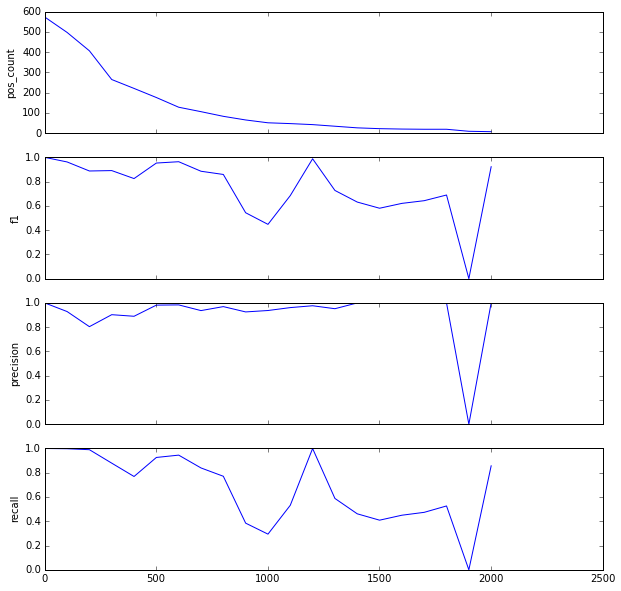

In [286]:
days_fig, (days_pos_count_ax, days_f1_ax, days_p_ax, days_r_ax) = plt.subplots(4,
                                                                               sharex=True,
                                                                               figsize = (10, 10))
days_pos_count_ax.plot(days_thresholds, days_quality['pos_count'])
days_pos_count_ax.set_ylabel('pos_count')
days_f1_ax.plot(days_thresholds, days_quality['f1'])
days_f1_ax.set_ylabel('f1')
days_p_ax.plot(days_thresholds, days_quality['p'])
days_p_ax.set_ylabel('precision')
days_r_ax.plot(days_thresholds, days_quality['r'])
days_r_ax.set_ylabel('recall')

# Регрессия Срока дожития

In [323]:
st_data = data[data['Выживаемость/Срок дожития/наблюдения'].fillna(0) != 0]
st_Y = st_data[['Выживаемость/Срок дожития/наблюдения', 'Выживаемость/Единицы измерения']].apply(lambda r: r['Выживаемость/Срок дожития/наблюдения'] * ST_UNITS_DAYS[r['Выживаемость/Единицы измерения']],
                                                                                                 axis = 'columns').as_matrix()
# st_X, st_X_labels = prepare_df(st_data)
# st_X, st_X_labels = prepare_df(st_data.drop(['Выживаемость/Срок дожития/наблюдения',
#                                              'Выживаемость/Единицы измерения'],
#                                             axis = 1))
st_X, st_X_labels = prepare_df(st_data.drop(list(TREATMENT_OUTCOME_COLUMNS), axis = 1))

(array([ 178.,  177.,   92.,   44.,   33.,   11.,   16.,    4.,   10.,
           3.,    3.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,
           1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    1.]),
 array([  1.00000000e+00,   2.10225000e+02,   4.19450000e+02,
          6.28675000e+02,   8.37900000e+02,   1.04712500e+03,
          1.25635000e+03,   1.46557500e+03,   1.67480000e+03,
          1.88402500e+03,   2.09325000e+03,   2.30247500e+03,
          2.51170000e+03,   2.72092500e+03,   2.93015000e+03,
          3.13937500e+03,   3.34860000e+03,   3.55782500e+03,
          3.76705000e+03,   3.97627500e+03,   4.18550000e+03,
          4.39472500e+03,   4.60395000e+03,   4.81317500e+03,
          5.02240000e+03,   5.23162500e+03,   5.44085000e+03,
          5.65007500e+03,   5.85930000e+03,   6.06852500e+03,
          6.27775000e+03,   6.48697500e+03,   6.69620000e+

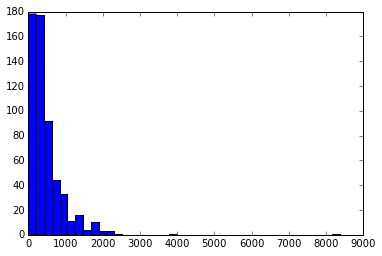

In [324]:
hist(st_Y, bins = 40)

In [325]:
print len(st_Y)
print st_X.shape

574
(574, 103)


In [326]:
base_reg = RandomForestRegressor()
# base_clf = ExtraTreesClassifier()
reg_params_dist = {
    "max_depth" : [3, 5, 10, 20, None],
    "n_estimators" : [50, 100, 200, 400],
    "min_samples_split" : [2, 4, 6],
    "min_samples_leaf" : [1, 2, 4],
    "bootstrap" : [True, False]
}

# base_clf = GradientBoostingClassifier()
# params_dist = {
#     "learning_rate" : [1e-3, 1e-2, 1e-1, 1],
#     "max_depth" : [3, 5, 10, 20, None],
#     "n_estimators" : [20, 50, 100, 200, 400],
#     "min_samples_split" : [2, 4, 6],
#     "min_samples_leaf" : [1, 2, 4],
#     "subsample" : [1.0, 0.8]
# }

# base_clf = AdaBoostClassifier()
# params_dist = {
#     "learning_rate" : [1e-1, 1, 2, 10],
#     "n_estimators" : [20, 50, 100, 200, 400],
# }

reg_n_sample_iters = 100
optimal_reg = RandomizedSearchCV(base_reg,
                                 reg_params_dist,
                                 scoring = 'mean_absolute_error',
                                 n_iter = reg_n_sample_iters,
                                 n_jobs = -1)
reg_res, reg_features = reg_cross_val(st_X, st_Y, st_X_labels, optimal_reg, folds_n = 3)

,evs,mae,r2
count,3.000000,3.000000,3.000000
mean,-0.092214,336.403257,-0.197083
std,0.151598,126.729274,0.151319
min,-0.266996,204.470780,-0.294249
25%,-0.140101,276.008120,-0.284256
50%,-0.013205,347.545460,-0.274263
75%,-0.004823,402.369496,-0.148500
max,0.003559,457.193532,-0.022737


# Связь Объективного клинического ответа и Времени выживаемости

In [276]:
or_st_data = data[(data['Выживаемость/Срок дожития/наблюдения'].fillna(0) != 0) & \
                  (data['Объективный клинический ответ/Значение'].fillna(0) != 0)]
or_st_data = DataFrame(data = {'Объективный клинический ответ/Значение' : or_st_data['Объективный клинический ответ/Значение'],
                               'Выживаемость/Срок дожития/наблюдения' : or_st_data[['Выживаемость/Срок дожития/наблюдения',
                                                                                    'Выживаемость/Единицы измерения']].apply(lambda r: r['Выживаемость/Срок дожития/наблюдения'] * ST_UNITS_DAYS[r['Выживаемость/Единицы измерения']],
                                                                                                                          axis = 'columns').as_matrix()
                              })
#or_st_data.set_index('Выживаемость/Срок дожития/наблюдения', inplace = True)
or_st_data.shape

(484, 2)

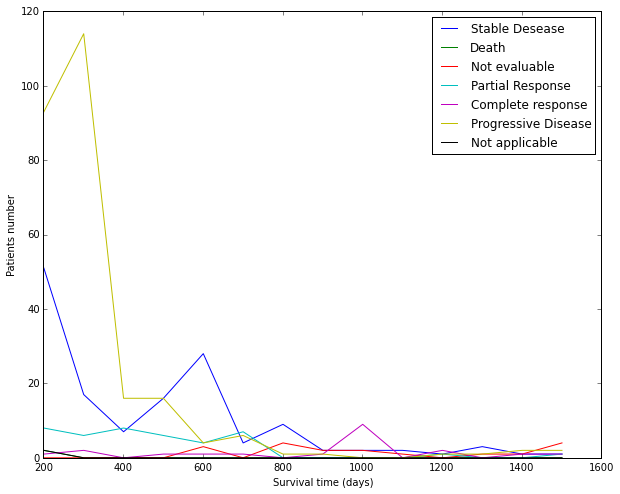

In [292]:
or_st_st_step = 100
or_st_st_min = int(min(or_st_data.index))
or_st_st_max = int(max(or_st_data.index) + or_st_st_step / 2)
or_st_st_bins = range(or_st_st_min + or_st_st_step,
                      or_st_st_max,
                      or_st_st_step)
def or_st_get_st_bin(st):
    return min(len(or_st_st_bins) - 1,
               int(float(st - or_st_st_min) / or_st_st_step))
or_values = list(set(or_st_data['Объективный клинический ответ/Значение']))
or_val_to_idx = { v : i for i, v in enumerate(or_values) }
st_to_or_data = numpy.zeros((len(or_st_st_bins), len(or_values)))
for _, row in or_st_data.iterrows():
    st_to_or_data[or_st_get_st_bin(row['Выживаемость/Срок дожития/наблюдения']),
                  or_val_to_idx[row['Объективный клинический ответ/Значение']]] += 1
    
or_st_fig, st_to_or_ax = plt.subplots(1, figsize = (10, 8))
for or_i, or_val in enumerate(or_values):
    st_to_or_ax.plot(or_st_st_bins, st_to_or_data[:,or_i], label = or_val)
st_to_or_ax.legend()
st_to_or_ax.set_ylabel('Patients number')
st_to_or_ax.set_xlabel('Survival time (days)')